# Определение возраста покупателей

## Исследовательский анализ данных

# Исследовательский анализ данных

Импорт используемых библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

Все данные находятся в папке '/datasets/faces/'. В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. Выгрузим их.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Данные выгружены, теперь пойдем по порядку:
1) Нужно узнать размер выборки;

In [4]:
labels.shape

(7591, 2)

Итого в нашем наборе 7591 объект и 2 признака - file_name и real_age (имена файлов и возраст объекта).

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков в данных нет.

2) Построим график распределения возраста в выборке;

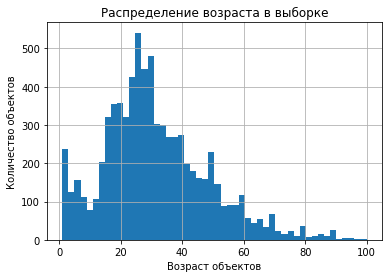

In [6]:
labels.hist(bins=50)
plt.xlabel('Возраст объектов')
plt.ylabel('Количество объектов')
plt.title('Распределение возраста в выборке');

На глаз сложно определить точную статистику, поэтому используем describe()

In [7]:
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


3) Теперь для наглядности выведем на экран 10 фотографий и посмотрим, как устроен датасет.

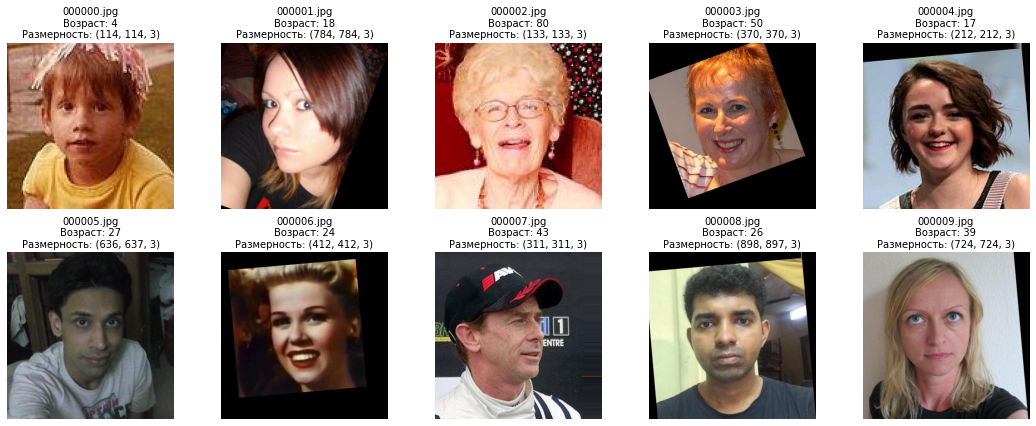

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()  

for i in range(0, 10):
    image = Image.open('/datasets/faces/final_files/00000' + str(i) + '.jpg')
    array = np.array(image)
    
    axs[i].imshow(array)
    axs[i].axis('off')
    axs[i].set_title(f"{labels.loc[i, 'file_name']}\nВозраст: {labels.loc[i, 'real_age']}\nРазмерность: {array.shape}", fontsize=10, pad=5)

plt.tight_layout()
plt.show();

Вывод:

1) Итого в нашем наборе 7591 объект и 2 признака - file_name и real_age (имена файлов и возраст объекта). Предположительно, данных хватит для обучения;
2) Пропусков в данных нет;
3) Нормальное распределение данных, со смещением влево. Большинство обьектов сконцентрировано в диапазоне от 20 до 30 лет, поэтому могут возникнуть проблемы с тем, что объекты вне этого возрастного диапазона будут предсказываться правильно с мепньшей вероятностью;
3) Странный пик присутсвует на графике ближе к возрасту 0-2 лет. Нужно будет разобраться что с этим делать.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1. / 255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```


Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 22s
   65536/94765736 [..............................] - ETA: 1:21
  245760/94765736 [..............................] - ETA: 41s 
  557056/94765736 [..............................] - ETA: 26s
 1327104/94765736 [..............................] - ETA: 14s
 3284992/94765736 [>.............................] - ETA: 7s 
 7077888/94765736 [=>............................] - ETA: 3s
10493952/94765736 [==>...........................] - ETA: 3s
14860288/94765736 [===>..........................] - ETA: 2s
19300352/94765736 [=====>........................] - ETA: 1s
23699456/94765736 [======>.......................] - ETA: 1s
27680768/94765736 [=======>......................] - ETA: 1s
31277056/94765736 [========>.....................] - ETA: 1s
35938304/94765736 [==========>...................] - ETA: 1s
39682048/94765736 [===========>..................] - ETA: 1s
43368448/94765736 [============>.................] - ETA: 0s
46882816/94765736 [=============>................] - ETA: 0s
50782208/94765736 [===============>..............] - ETA: 0s
55058432/94765736 [================>.............] - ETA: 0s
58589184/94765736 [=================>............] - ETA: 0s
62701568/94765736 [==================>...........] - ETA: 0s
66781184/94765736 [====================>.........] - ETA: 0s
70467584/94765736 [=====================>........] - ETA: 0s
74489856/94765736 [======================>.......] - ETA: 0s
78495744/94765736 [=======================>......] - ETA: 0s
82370560/94765736 [=========================>....] - ETA: 0s
86048768/94765736 [==========================>...] - ETA: 0s
90259456/94765736 [===========================>..] - ETA: 0s
94117888/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
2024-10-24 13:38:05.638900: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-10-24 13:38:06.001030: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 81s - loss: 208.6811 - mae: 10.5173 - val_loss: 310.0539 - val_mae: 14.3723
Epoch 2/10
356/356 - 51s - loss: 83.2120 - mae: 6.9460 - val_loss: 121.7859 - val_mae: 8.3981
Epoch 3/10
356/356 - 51s - loss: 56.9913 - mae: 5.7951 - val_loss: 85.5890 - val_mae: 6.9585
Epoch 4/10
356/356 - 52s - loss: 45.3739 - mae: 5.1297 - val_loss: 88.3472 - val_mae: 7.1077
Epoch 5/10
356/356 - 51s - loss: 33.5261 - mae: 4.4322 - val_loss: 73.5680 - val_mae: 6.4245
Epoch 6/10
356/356 - 51s - loss: 25.9449 - mae: 3.8878 - val_loss: 64.5338 - val_mae: 5.9640
Epoch 7/10
356/356 - 51s - loss: 20.1884 - mae: 3.4191 - val_loss: 75.2686 - val_mae: 6.6739
Epoch 8/10
356/356 - 51s - loss: 16.8926 - mae: 3.1361 - val_loss: 71.1987 - val_mae: 6.2456
Epoch 9/10
356/356 - 51s - loss: 14.2159 - mae: 2.8668 - val_loss: 63.8153 - val_mae: 5.9877
Epoch 10/10
356/356 - 51s - loss: 12.6134 - mae: 2.7121 - val_loss: 63.3040 - val_mae: 6.0586
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 63.3040 - mae: 6.0586


```

## Анализ обученной модели

Напишите выводы здесь

Вывод:
Цель обучения нейросети была успешно достигнута. В результате тестирования модели на валидационных данных, получен показатель «MAE» равный 6.0586, что ниже целевого значения в 8. Это означает, что модель ошибается в определении возраста человека по его фотографии не более чем на 6.0586 лет.

Однако с точки зрения применения данной модели в реальном бизнесе, результат можно считать не совсем удовлетворительным. Основная причина кроется в используемом датасете, который в основном состоит из изображений людей среднего возраста. Фотографий детей и пожилых людей недостаточно для полноценного обучения. Если дополнить датасет изображениями из этих возрастных категорий, качество модели может значительно улучшиться. Кроме того, на точность обучения также могло повлиять округление целевых значений до пяти категорий, что можно исправить только с помощью более тщательной разметки данных.

Обученная модель может быть рекомендована для использования в сервисах, анализирующих покупки и предлагающих товары, соответствующие интересам определенной возрастной группы. Однако ее не стоит применять для контроля добросовестности кассиров при продаже алкоголя.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы